In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Импортируем все необходимые библиотеки

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor 
import numpy as np

Загружаем данные и смотрим на них

https://www.kaggle.com/tsarkov90/crime-in-russia-20032020

In [ ]:
data = pd.read_csv('/content/drive/My Drive/crime.csv')

In [ ]:
data

,month,Total_crimes,Serious,Huge_damage,Ecological,Terrorism,Extremism,Murder,Harm_to_health,Rape,Theft,Vehicle_theft,Fraud_scam,Hooligan,Drugs,Weapons
0,01.01.2003,214587.0,88203.0,20162.0,1216.0,630.0,13.0,2749.0,5559.0,574.0,81014.0,3549.0,7731.0,10560.0,16006.0,4661.0
1,01.02.2003,221928.0,88863.0,20889.0,1701.0,678.0,5.0,2444.0,4732.0,515.0,95970.0,3697.0,7607.0,10816.0,16839.0,5364.0
2,01.03.2003,248452.0,101349.0,24053.0,1817.0,809.0,10.0,2864.0,4851.0,560.0,79420.0,4327.0,9437.0,11813.0,20176.0,5938.0
3,01.04.2003,236299.0,91625.0,19754.0,2449.0,892.0,10.0,2919.0,4722.0,668.0,95215.0,5345.0,7824.0,12636.0,16614.0,5230.0
4,01.05.2003,230931.0,89615.0,17519.0,3530.0,796.0,20.0,2713.0,4895.0,688.0,94505.0,6374.0,7122.0,12234.0,14413.0,5112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,01.09.2019,166208.0,38967.0,64283.0,1858.0,122.0,48.0,555.0,1570.0,306.0,67006.0,1903.0,21557.0,155.0,15100.0,1945.0
201,01.10.2019,199038.0,53319.0,81775.0,2322.0,111.0,52.0,668.0,1846.0,223.0,81053.0,2197.0,27980.0,180.0,20510.0,1744.0
202,01.11.2019,148104.0,31652.0,49623.0,1581.0,149.0,27.0,622.0,1467.0,246.0,57434.0,1344.0,19794.0,132.0,11067.0,1742.0
203,01.12.2019,155512.0,38470.0,60742.0,1526.0,164.0,52.0,534.0,1644.0,134.0,63327.0,1374.0,22588.0,155.0,13451.0,1754.0


Преобразовываем столбец даты в формат месяц.год

In [ ]:
data['месяц_год'] = data['month'].map(lambda x: x[3:])
data['общее_количество_преступлений'] = data['Total_crimes']

In [ ]:
data[['месяц_год', 'общее_количество_преступлений']]

,месяц_год,общее_количество_преступлений
0,01.2003,214587.0
1,02.2003,221928.0
2,03.2003,248452.0
3,04.2003,236299.0
4,05.2003,230931.0
...,...,...
200,09.2019,166208.0
201,10.2019,199038.0
202,11.2019,148104.0
203,12.2019,155512.0


Преобразовываем месяц.год в удобных для обучения компьютера формат: нумерация от 1 (01.2003) до 204 (01.2020)

In [ ]:
data['месяц_год_нумированный'] = [i for i in range(data['month'].count())]

In [ ]:
data[['месяц_год','месяц_год_нумированный','общее_количество_преступлений']]

,месяц_год,месяц_год_нумированный,общее_количество_преступлений
0,01.2003,0,214587.0
1,02.2003,1,221928.0
2,03.2003,2,248452.0
3,04.2003,3,236299.0
4,05.2003,4,230931.0
...,...,...,...
200,09.2019,200,166208.0
201,10.2019,201,199038.0
202,11.2019,202,148104.0
203,12.2019,203,155512.0


Задаём независимую переменную х (преобразованная нумерованная дата) и предсказываемую зависимую переменную у (общее количество преступлений)

In [ ]:
x = data.iloc[:, 16].values
y = data.iloc[:, 1].values

In [ ]:
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Нарисуем график у(х)

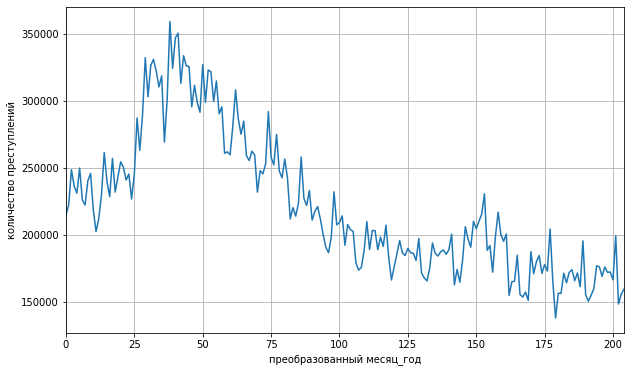

In [ ]:
plt.figure(figsize=(10, 6))
plt.xlim(xmin=0, xmax=max(data['month_n']))
plt.xlabel('преобразованный месяц_год')
plt.ylabel('количество преступлений')
plt.grid()
plt.plot(x, y)


Т.к. модели регрессии принимают х начиная с 2х измерений, то преобразуем [0,1,2..204] в [[0,],[1,],[2,]..[204,]]

Делим выборку на тренировочную и тестовую 40%

In [ ]:
x = x.reshape(-1, 1)
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.4, random_state=1)


Используем Decision Tree Regression c глубиной 5 в качестве модели обучения

In [ ]:
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(xtrain, ytrain)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Предсказываем на тестовой выборке результат и считаем метрику MSE, RMSE

In [ ]:
ypred = dtr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 386615341.74
RMSE: 19662.54


In [ ]:
x_te = [int(i) for i in xtest]

In [ ]:
def num_to_date(n):
  y = str(n//12+2003)
  m = str(n%12+1)
  return m+'.'+y

Создаём набор данных с ответами data_an, cостоящий из:

*   возвращённые нумерованные даты 'x_тестовое' в человекочитаемый вид 'x_тестовое_дата' с помощью функции num_to_date(n)
*   тестовые значения у
*   значение у, предсказанное моделью dtr






In [ ]:
d = {'x_тестовое': x_te}
data_an = pd.DataFrame(data=d)
data_an['x_тестовое_дата'] = data_an['x_тестовое'].map(lambda x: num_to_date(x))
data_an['y_тестовое'] = ytest
data_an['y_предсказанное_dtr'] = ypred

In [ ]:
num_to_date(13)

'2.2004'

In [ ]:
data_an

,x_тестовое,x_тестовое_дата,y_тестовое,y_предсказанное_dtr
0,78,7.2009,247575.0,262537.833333
1,97,2.2011,198122.0,186489.000000
2,151,8.2015,209971.0,209251.750000
3,44,9.2006,325988.0,317365.111111
4,40,5.2006,346939.0,317365.111111
...,...,...,...,...
77,66,7.2008,258726.0,281737.750000
78,114,7.2012,188732.0,188773.208333
79,54,7.2007,299382.0,317365.111111
80,93,10.2010,211816.0,220874.000000


Тренеруем вторую модель XGBoost Regression

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 1,
                          max_depth = 4, alpha = 10, n_estimators = 11)

In [ ]:
xg_reg.fit(xtrain,ytrain)

preds = xg_reg.predict(xtest)

[14:24:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Считаем RMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(ytest, preds))
print("RMSE: %f" % (rmse))

RMSE: 17949.698561


Добавляем предсказанные ответы в таблицу с ответами

In [ ]:
data_an['y_предсказанное_xgb'] = preds

In [ ]:
data_an

,x_тестовое,x_тестовое_дата,y_тестовое,y_предсказанное_dtr,y_предсказанное_xgb
0,78,7.2009,247575.0,262537.833333,249392.078125
1,97,2.2011,198122.0,186489.000000,187894.968750
2,151,8.2015,209971.0,209251.750000,213707.421875
3,44,9.2006,325988.0,317365.111111,331530.812500
4,40,5.2006,346939.0,317365.111111,331530.812500
...,...,...,...,...,...
77,66,7.2008,258726.0,281737.750000,277558.437500
78,114,7.2012,188732.0,188773.208333,198861.406250
79,54,7.2007,299382.0,317365.111111,309754.312500
80,93,10.2010,211816.0,220874.000000,222206.421875


Посчитаем процентные ошибки каждого ответа и добавим в таблицу ответов, используя функцию er_percent

In [ ]:
def er_percent(df, col_test, col_pred, name_er_col):
  df[name_er_col] = [round(abs(df[col_pred][i]-df[col_test][i])/df[col_test][i]*100, 2) for i in range(df[col_test].count())]

In [ ]:
er_percent(data_an, 'y_тестовое', 'y_предсказанное_dtr', 'ошибка_dtr,%')
er_percent(data_an, 'y_тестовое', 'y_предсказанное_xgb', 'ошибка_xgbr,%')

In [ ]:
data_an

,x_тестовое,x_тестовое_дата,y_тестовое,y_предсказанное_dtr,y_предсказанное_xgb,"ошибка_dtr,%","ошибка_xgbr,%"
0,78,7.2009,247575.0,262537.833333,249392.078125,6.04,0.73
1,97,2.2011,198122.0,186489.000000,187894.968750,5.87,5.16
2,151,8.2015,209971.0,209251.750000,213707.421875,0.34,1.78
3,44,9.2006,325988.0,317365.111111,331530.812500,2.65,1.70
4,40,5.2006,346939.0,317365.111111,331530.812500,8.52,4.44
...,...,...,...,...,...,...,...
77,66,7.2008,258726.0,281737.750000,277558.437500,8.89,7.28
78,114,7.2012,188732.0,188773.208333,198861.406250,0.02,5.37
79,54,7.2007,299382.0,317365.111111,309754.312500,6.01,3.46
80,93,10.2010,211816.0,220874.000000,222206.421875,4.28,4.91


Считаем MAPE обеих моделей и выводим вместе с RMSE

In [ ]:
mape_dtr = round(data_an['ошибка_dtr,%'].mean(), 2)
mape_xgbr = round(data_an['ошибка_xgbr,%'].mean(), 2)
print(f'средняя процентная ошибка модели dtr: {mape_dtr}%\nсредняя процентная ошибка модели xgbr: {mape_xgbr}%')
print(f'\nкорень из среднеквадратической ошибки dtr: {round(mse**(1/2.0), 3)}\nкорень из среднеквадратической ошибки xgbr: {round(rmse, 3)}')

средняя процентная ошибка модели dtr: 7.01%
средняя процентная ошибка модели xgbr: 5.83%

корень из среднеквадратической ошибки dtr: 19662.537
корень из среднеквадратической ошибки xgbr: 17949.699
